In [ ]:
#@title
import keras
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.optimizers import adam_v2
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import os
import cv2
import time
import random
from numpy import *

In [ ]:
image_features_x=np.load('/content/drive/MyDrive/processed-data/image_features_x.npy')

In [ ]:
# image_features_y=np.load('/content/drive/MyDrive/processed-data/image_features_y.npy')

In [ ]:
audio_array=np.load('/content/drive/MyDrive/processed-data/audio_np_array.npy')

In [ ]:
audio_array.shape

(7442, 181)

In [ ]:
split = train_test_split(audio_array, image_features_x, test_size=0.1, random_state=42)
(trainAttr, testAttr, trainImagesX, testImagesX) = split

In [ ]:
del image_features_x
del audio_array

In [ ]:
trainY_num = trainAttr[:,[-1]]
testY_num = testAttr[:,[-1]]

In [ ]:
trainAttrX = np.delete(trainAttr, -1, axis=1)
testAttrX = np.delete(testAttr, -1, axis=1)

In [ ]:
del trainAttr
del testAttr

In [ ]:
trainY = np_utils.to_categorical(trainY_num)
testY = np_utils.to_categorical(testY_num)

In [ ]:
del trainY_num
del testY_num

In [ ]:
print((trainAttrX.shape, trainY.shape))
print((testAttrX.shape, testY.shape))

((6697, 180), (6697, 6))
((745, 180), (745, 6))


In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(277,277,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(277,277,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.5))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.5))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(6))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

In [ ]:
# plot_model(AlexNet, "AlexNet.png", show_shapes=True)

In [ ]:
dim=180 # no. of features extracted from audio files
num_classes=6

In [ ]:
mlpclassifier=Sequential()
mlpclassifier.add(Dense(120, input_dim=dim, activation="relu", name="mlp_dense_1"))
mlpclassifier.add(Dense(60, activation="relu", name="mlp_dense_2"))
mlpclassifier.add(Dense(num_classes, activation='softmax', name="mlp_dense_3"))

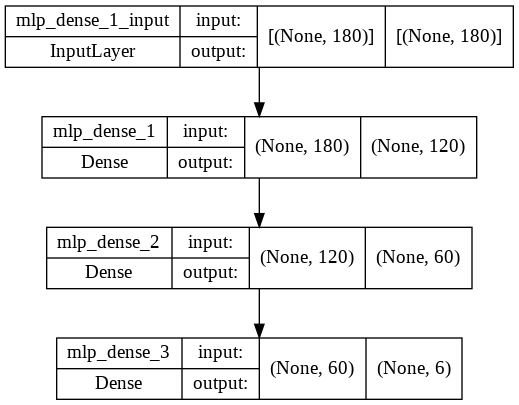

In [ ]:
plot_model(mlpclassifier, "mlpclassifier.png", show_shapes=True)

In [ ]:
# mlpclassifier.output and mlpclassifier_output are the same
print(mlpclassifier.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='mlp_dense_3/Softmax:0', description="created by layer 'mlp_dense_3'")


In [ ]:
combinedInput = Concatenate()([mlpclassifier.output, AlexNet.output])
x = Dense(8, activation="relu")(combinedInput)
x = Dense(6, activation="softmax")(x)
# our final model will accept numerical data on the MLP
# input and images on the CNN input, outputting the rating of the sentiment
model = Model(inputs=[mlpclassifier.input, AlexNet.input], outputs=x)

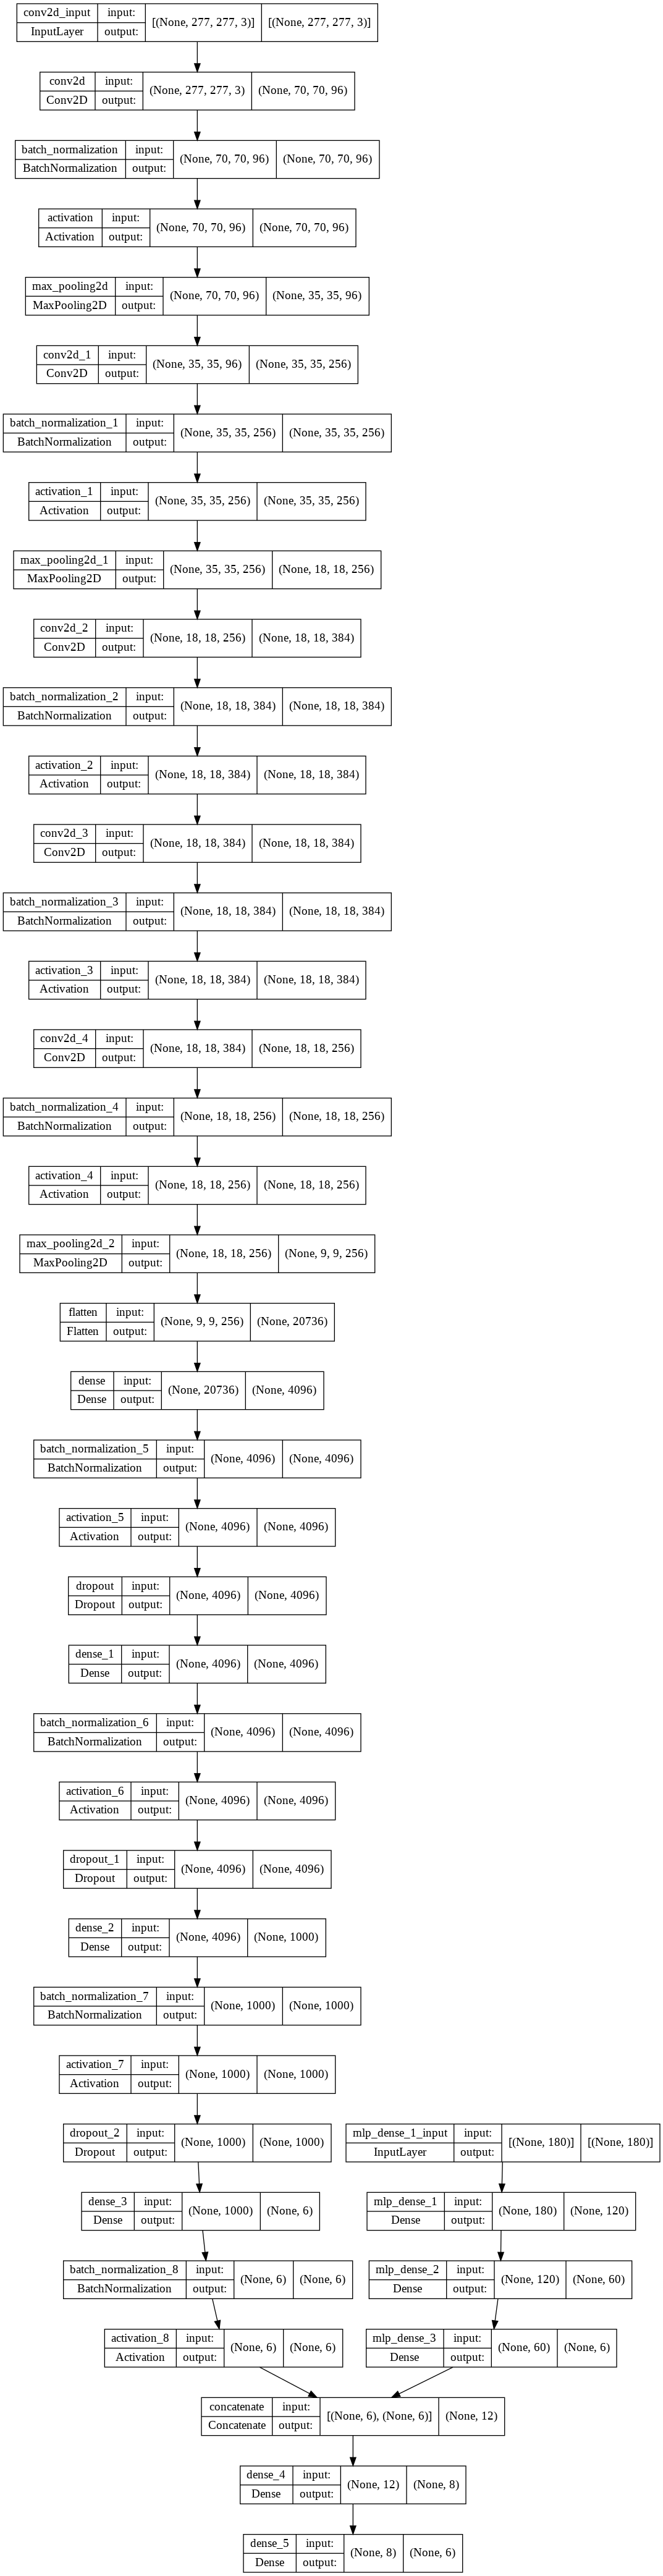

In [ ]:
plot_model(model, "combinedmodel.png", show_shapes=True)

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 277, 277, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 70, 70, 96)   34944       ['conv2d_input[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 70, 70, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=5, min_lr=1e-9) 

In [ ]:
# train the model
model.fit(
	x=[trainAttrX, trainImagesX], y=trainY,
	# validation_split=0.1,
	validation_data=([testAttrX, testImagesX], testY),
	callbacks = [lrr],
	epochs=50, batch_size=32)

Epoch 1/50
210/210 [==============================] - 29s 67ms/step - loss: 1.7682 - accuracy: 0.2256 - val_loss: 1.7209 - val_accuracy: 0.2779 - lr: 0.0010
Epoch 2/50
210/210 [==============================] - 13s 60ms/step - loss: 1.6578 - accuracy: 0.3013 - val_loss: 1.5871 - val_accuracy: 0.3369 - lr: 0.0010
Epoch 3/50
210/210 [==============================] - 13s 60ms/step - loss: 1.5716 - accuracy: 0.3318 - val_loss: 1.5285 - val_accuracy: 0.3570 - lr: 0.0010
Epoch 4/50
210/210 [==============================] - 13s 60ms/step - loss: 1.5372 - accuracy: 0.3428 - val_loss: 1.5249 - val_accuracy: 0.3436 - lr: 0.0010
Epoch 5/50
210/210 [==============================] - 13s 60ms/step - loss: 1.5220 - accuracy: 0.3537 - val_loss: 1.4804 - val_accuracy: 0.3866 - lr: 0.0010
Epoch 6/50
210/210 [==============================] - 13s 60ms/step - loss: 1.5097 - accuracy: 0.3618 - val_loss: 1.4704 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 7/50
210/210 [==============================] - 13s 

In [ ]:
# make predictions on the testing data
preds = model.predict([testAttrX, testImagesX])

In [ ]:
results = model.evaluate([testAttrX, testImagesX], testY, batch_size=32)
print("test loss, test accuracy:", results)

24/24 [==============================] - 1s 26ms/step - loss: 1.4269 - accuracy: 0.3973
test loss, test accuracy: [1.4269126653671265, 0.39731544256210327]


In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
np.set_printoptions(precision=2)

In [ ]:
y_true=np.argmax(testY,axis=1)
y_pred=np.argmax(preds, axis=1)

In [ ]:
confusion_mtx=confusion_matrix(y_true, y_pred)

class_names= ['ANGER','DISGUST','FEAR','HAPPY','NEUTRAL','SAD']

Confusion matrix, without normalization


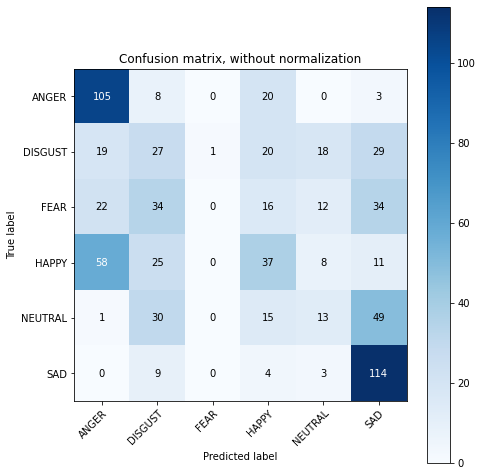

In [ ]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

Normalized confusion matrix


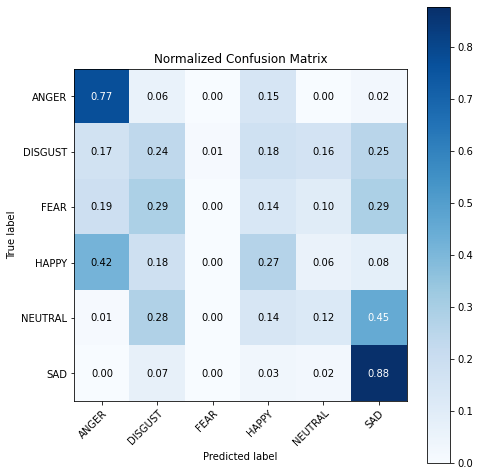

In [ ]:
# Plotting Normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize=True, title = 'Normalized Confusion Matrix')